Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [4]:
WELLS = ["CCS1", "VW1"]               #wells considered
MODEL_HYPERPARAMETERS = {
            'n_estimators':100,       #number of decision trees in forest
            'min_samples_split':2,    #min num samples requires to split internal node
            'min_samples_leaf':1,     #min num samples required in a leaf node
            'max_features':30,        #maximum number of features trees split based on
            'max_depth':25,           #maximum depth of a decision tree
            'bootstrap':True,         #randomly samples data drom dataset
            'random_state':42         #for reproducibility
}
FORMATIONS = [                        #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"

Imports

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, \
mean_absolute_error, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
RandomizedSearchCV, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from random import randint, uniform
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os
import math

Retrieve Data and Labels

In [6]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 24)
CCS1 : Shape of labels= (4217, 2)
CCS1 : Shape of merged= (4217, 25)
VW1 : Shape of inputs= (3999, 24)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 25)
Num features: 22


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [7]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [8]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [9]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
   {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Prediction Plotting Tools

In [17]:
def print_metrics(accuracy, f1):
  """
  Print accuracy and f1 scores.
  """
  print(f"Average accuracy is {(accuracy * 100).round(2)}%")
  print(f"Average f1 is {(f1 * 100).round(2)}%")

In [20]:
def plot_depths_with_labels(curr_well, depths, y_preds, test_labels):
  """
  Plots the depths that are predicted to contain fractures alongside the
  actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  plt.title(curr_well + "(Predictions | Truth)")
  #plt.barh(depths, y_pred, color="red")
  y_preds = [-y for y in y_preds]
  plt.barh(depths, y_preds, color="blue")
  plt.barh(depths, test_labels, color="gray")
  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_RFPlot.png', format='png', dpi=1200)
  plt.show()

Train/Test Function

In [18]:
def trainandpredict_xgb(X_train, X_test, y_train, y_test):
    """
    Trains random forest classifier and then tests it with test dataset.
    Returns the model's current performance metrics.
    """
    #initialize a random forest classifier
    rfc = RandomForestClassifier(**MODEL_HYPERPARAMETERS)

    #train model and make predictions based on test set
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    #calculuate and return performance
    y_pred_train = rfc.predict(X_train)
    print("\nResults for training:")
    print_metrics(accuracy_score(y_pred_train, y_train),
                 f1_score(y_pred_train, y_train))
    print("\nResults for testing:")
    print_metrics(accuracy_score(y_pred, y_test),
                 f1_score(y_pred, y_test))


    return y_pred


Training on ['VW1'],  testing on CCS1
Before PCA Xtrain, Xtest shapes: (3999, 22), (4217, 22)
After PCA Xtrain, Xtest shapes:   (3999, 6), (4217, 6)

Results for training:
Average accuracy is 100.0%
Average f1 is 100.0%

Results for testing:
Average accuracy is 83.5%
Average f1 is 1.97%


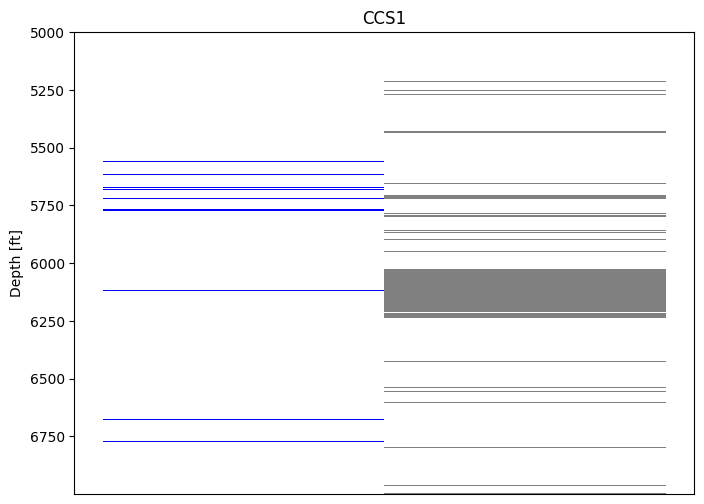


Training on ['CCS1'],  testing on VW1
Before PCA Xtrain, Xtest shapes: (4217, 22), (3999, 22)
After PCA Xtrain, Xtest shapes:   (4217, 5), (3999, 5)

Results for training:
Average accuracy is 99.98%
Average f1 is 99.92%

Results for testing:
Average accuracy is 77.57%
Average f1 is 12.49%


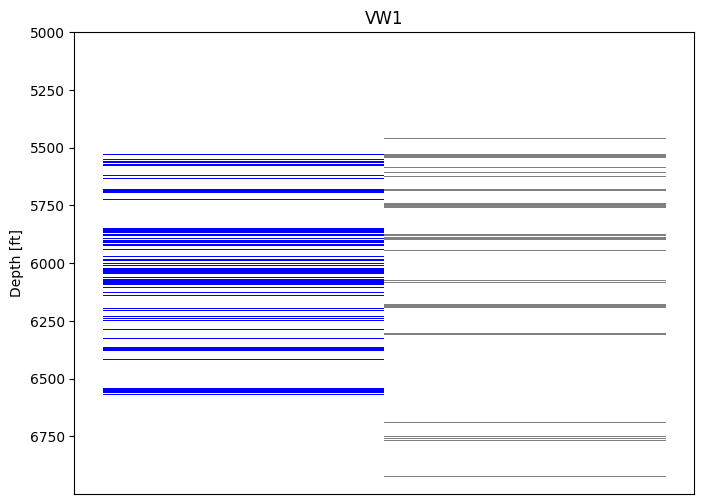

In [19]:
for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  testset = datasets[curr_well]
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
  testing on {curr_well}")
  trainsets = [datasets[well] for well in WELLS if well != curr_well]
  trainset = pd.concat(trainsets)
  test_depths = testset["DEPT"] #save for plotting

  ### optional undersampling of majority class
  #trainset = balance_dataset(trainset)

  X_train = np.array(trainset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_train = np.array(trainset["HAS_FRAC"])
  X_test = np.array(testset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_test = np.array(testset["HAS_FRAC"])

  ### optional data preprocessing steps
  X_train, X_test = normalize(X_train, X_test)
  #X_train, X_test = apply_PCA(X_train, X_test)

  ### train/test model and plot results
  y_pred = trainandpredict_xgb(X_train, X_test, y_train, y_test)
  plot_depths_with_labels(curr_well, test_depths, y_pred, y_test)